In [44]:
import librosa
import numpy
import pandas

import matplotlib.pyplot as plt
import IPython.display
import librosa.display

import sklearn.preprocessing
import scipy.ndimage

In [4]:
noisy_with_bird = ['https://storage.googleapis.com/dcase2018-bad/birdvox/wav/008d8612-f008-4a75-a9d4-e8292c8588cf.wav'
 'https://storage.googleapis.com/dcase2018-bad/birdvox/wav/00960c0b-16e5-4a5b-a5e7-ac1fef8f488f.wav'
 'https://storage.googleapis.com/dcase2018-bad/birdvox/wav/00adbc49-77ef-4b7e-a453-cbb4ee011e11.wav']

nosy_without_bird = ['https://storage.googleapis.com/dcase2018-bad/birdvox/wav/00837ab5-0ce0-4448-af39-a56d95be35bf.wav'
 'https://storage.googleapis.com/dcase2018-bad/birdvox/wav/00a76d1a-d12b-411e-a4ca-61720d79aaba.wav'
 'https://storage.googleapis.com/dcase2018-bad/birdvox/wav/00c183b5-9207-43ec-a8ea-0aca76d1c8f5.wav']

clear_with_bird = ['https://storage.googleapis.com/dcase2018-bad/warblr10k_public/wav/4dd5046d-c962-4f02-a820.wav'
 'https://storage.googleapis.com/dcase2018-bad/warblr10k_public/wav/3661273c-19b9-4ea0-abc5.wav'
 'https://storage.googleapis.com/dcase2018-bad/warblr10k_public/wav/960784f4-34aa-4235-9d9c.wav']

caralarm_and_bird = ['https://storage.googleapis.com/dcase2018-bad/warblr10k_public/wav/13562d9b-aa0b-42ca-9198.wav']

In [4]:

def low_level_features(y, sr, contrast=False):
    S, phase = librosa.magphase(librosa.stft(y=y))
    
    spectral_features = [
        'spectral_centroid',
        'spectral_bandwidth',
        'spectral_flatness',
        'spectral_rolloff',
        'rmse',
    ]
    def extract_spectral(feature):
        func = getattr(librosa.feature, feature)
        d = func(S=S).reshape(-1)
        return d
    
    features = { f: extract_spectral(f) for f in spectral_features }
    features['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(y).reshape(-1)

    if contrast:
        spectral_contrast = librosa.feature.spectral_contrast(S=S, n_bands=6)
        for band in range(0, spectral_contrast.shape[0]):
            name = 'spectral_contrast_{}'.format(band)
            features[name] = spectral_contrast[band,:]
    
    n_frames = len(features['rmse'])
    return pandas.DataFrame(features, index=range(0, n_frames))


/usr/lib/python3.7/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
/usr/lib/python3.7/site-packages/pandas/plotting/_core.py:1804: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


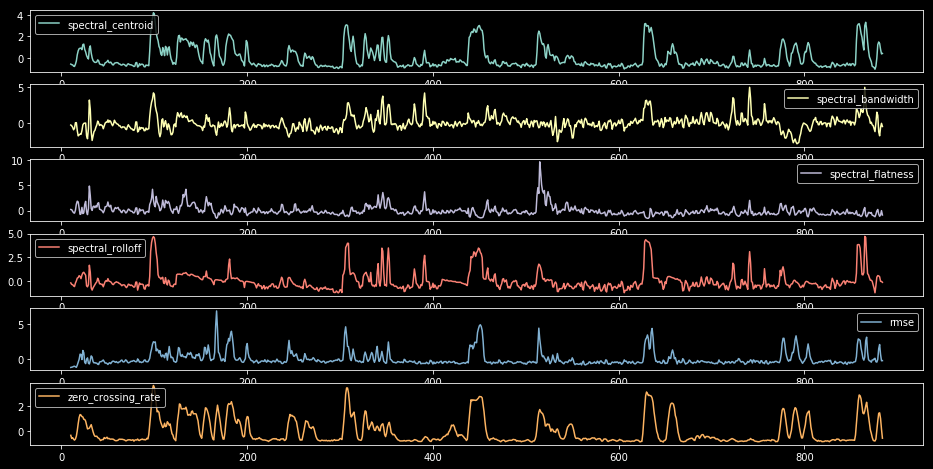

In [58]:
plt.style.use('dark_background')

def plot_lowlevel(f, out=None, figsize=(16,8)):
    y, sr = librosa.load(f, sr=44100)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    scaler = sklearn.preprocessing.StandardScaler()
    lowlevel = low_level_features(y, sr)
    lowlevel = lowlevel.tail(n=-10) # cut off abnormal values caused by start
    lowlevel[:] = scaler.fit_transform(lowlevel[:].astype(numpy.float64))

    axs = lowlevel.plot(subplots=True, ax=ax, figsize=figsize)    
    if out:
        fig.savefig(out, bbox_inches='tight', pad_inches=0)
    
    return fig

f = 'sounds/4dd5046d-c962-4f02-a820.wav'
plot_lowlevel(f, out='lowlevel.png');

In [9]:
IPython.display.Audio(f)

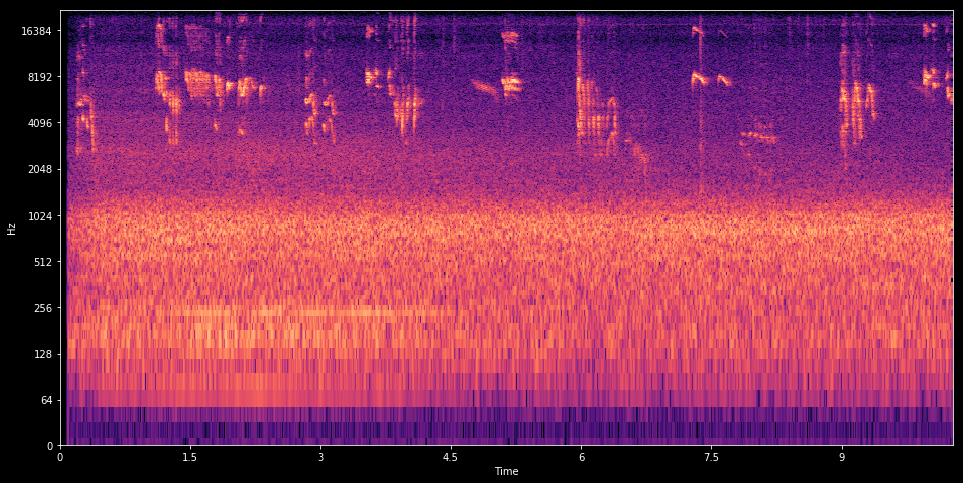

In [55]:
def plot_spectrogram(f, out=None, figsize=(16,8)):
    y, sr = librosa.load(f, sr=44100)
    
    fig, ax = plt.subplots(1, figsize=figsize)

    S = librosa.amplitude_to_db(numpy.abs(librosa.stft(y)), ref=numpy.max)
    librosa.display.specshow(S, y_axis='log', x_axis='time', sr=sr)
    
    if out:
        fig.savefig(out, bbox_inches='tight', pad_inches=0)
    return fig

plot_spectrogram(f, out='spec.png');


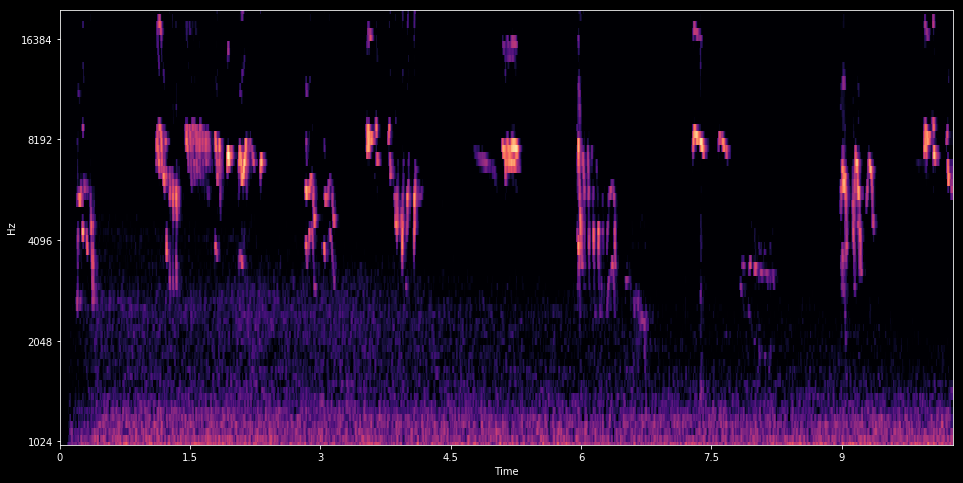

In [56]:


def plot_melspectrogram(f, out=None, figsize=(16,8), meansubtract=False, medianfilter=None, fmin=1000):
    y, sr = librosa.load(f, sr=44100)
    
    fig, ax = plt.subplots(1, figsize=figsize)

    mels = librosa.feature.melspectrogram(y, sr=sr, fmin=fmin, fmax=20000, n_mels=64)
    S = librosa.amplitude_to_db(mels, ref=numpy.max)
    if meansubtract:
        S = S - (numpy.mean(S, axis=1, keepdims=True) + 1e-8)
    if medianfilter:
        S = scipy.ndimage.median_filter(S, medianfilter)

    librosa.display.specshow(S, ax=ax, y_axis='mel', x_axis='time', fmin=fmin, fmax=20000, sr=sr)
    
    if out:
        fig.savefig(out, bbox_inches='tight', pad_inches=0)
    return fig

plot_melspectrogram(f, out='melspec.png');

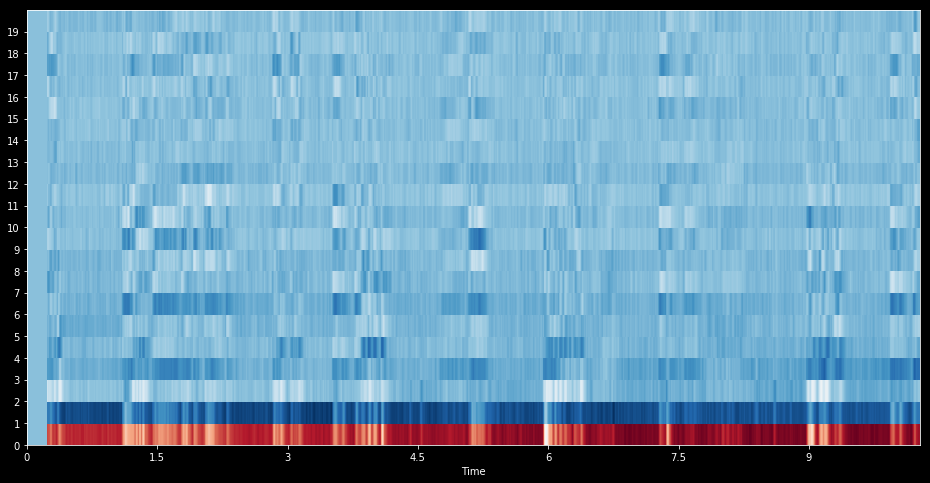

In [57]:


def plot_mfcc(f, out=None, figsize=(16,8), fmin=1000):
    y, sr = librosa.load(f, sr=44100)
    
    fig, ax = plt.subplots(1, figsize=figsize)

    mfcc = librosa.feature.mfcc(y, sr=sr, fmin=fmin, fmax=20000, n_mfcc=20, hop_length=512, n_fft=2048)
    mfcc[:,0:20] = 0.0 # Ignore start artifacts
    m = librosa.display.specshow(mfcc, cmap='RdBu', ax=ax, x_axis='time', sr=sr)
    mesh = ax.get_children()[0] # HACK
    ax.set_yticks(range(0,mfcc.shape[0]))
    #fig.colorbar(mesh)
    
    if out:
        fig.savefig(out, bbox_inches='tight', pad_inches=0)
    return fig

plot_mfcc(f, out='mfcc.png');

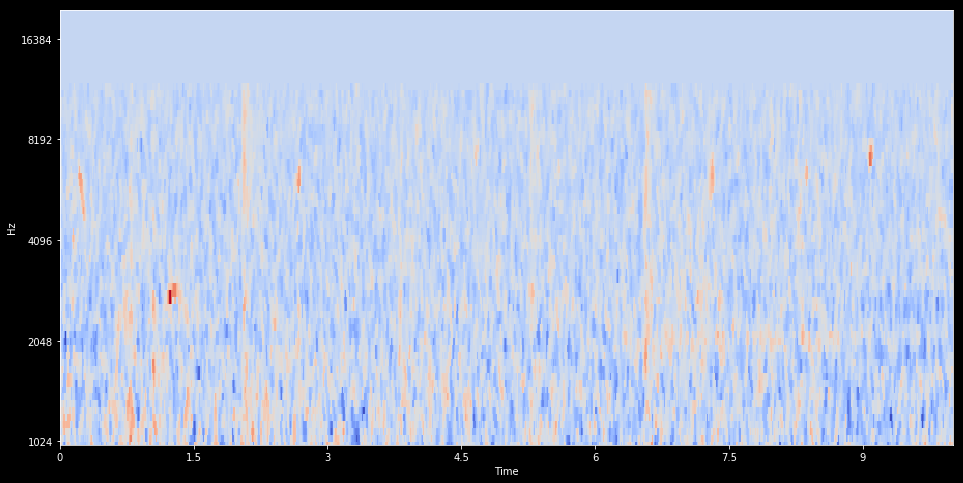

In [50]:
n = '00adbc49-77ef-4b7e-a453-cbb4ee011e11.wav'
plot_melspectrogram(n, out='', meansubtract=True, medianfilter=(3, 3));

In [20]:
IPython.display.Audio(n)

/usr/lib/python3.7/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
/usr/lib/python3.7/site-packages/pandas/plotting/_core.py:1804: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


plotted images/bird_noisy_lowlevel.png
plotted images/bird_noisy_mfcc.png
plotted images/bird_noisy_melspec.png
plotted images/bird_noisy_spectrogram.png
plotted images/bird_noisy_melspec_filtered.png


/usr/lib/python3.7/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
/usr/lib/python3.7/site-packages/pandas/plotting/_core.py:1804: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


plotted images/bird_clear_lowlevel.png
plotted images/bird_clear_mfcc.png
plotted images/bird_clear_melspec.png
plotted images/bird_clear_spectrogram.png
plotted images/bird_clear_melspec_filtered.png


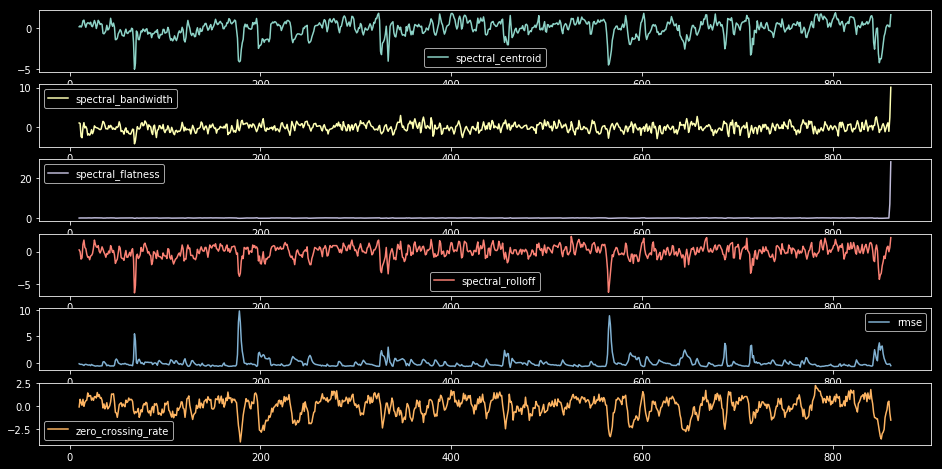

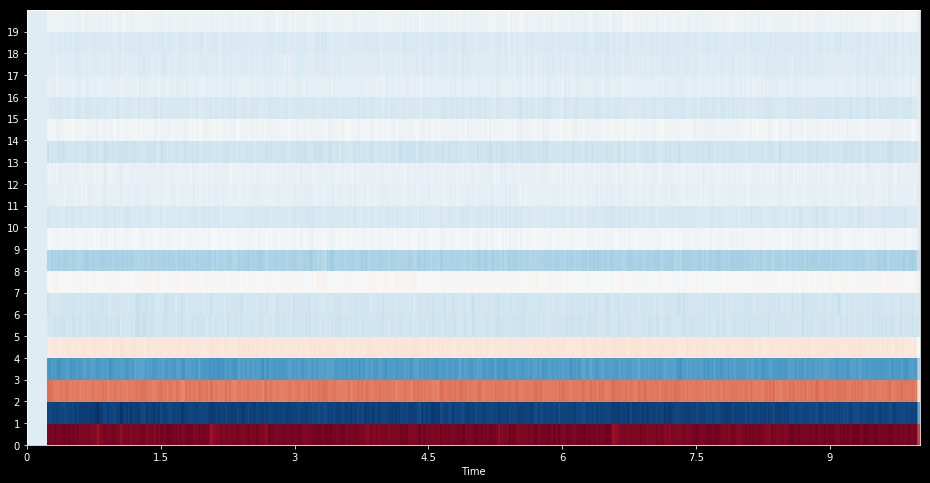

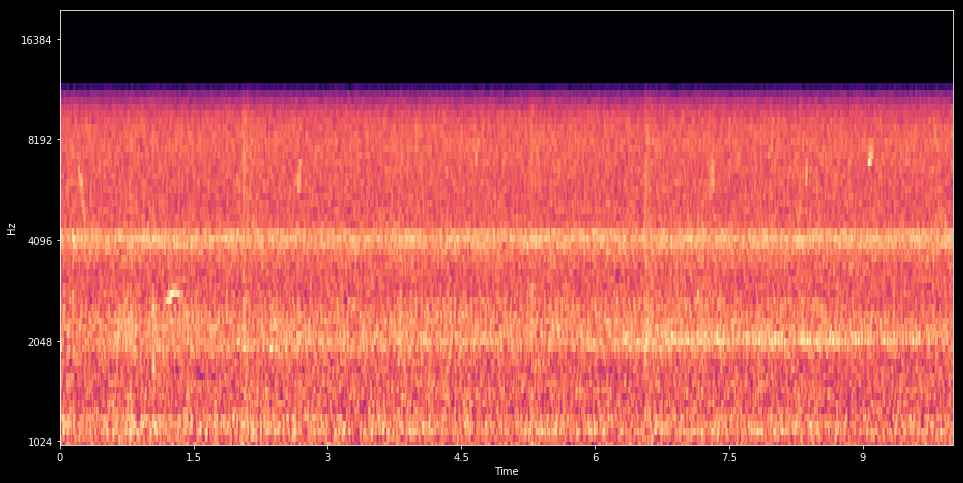

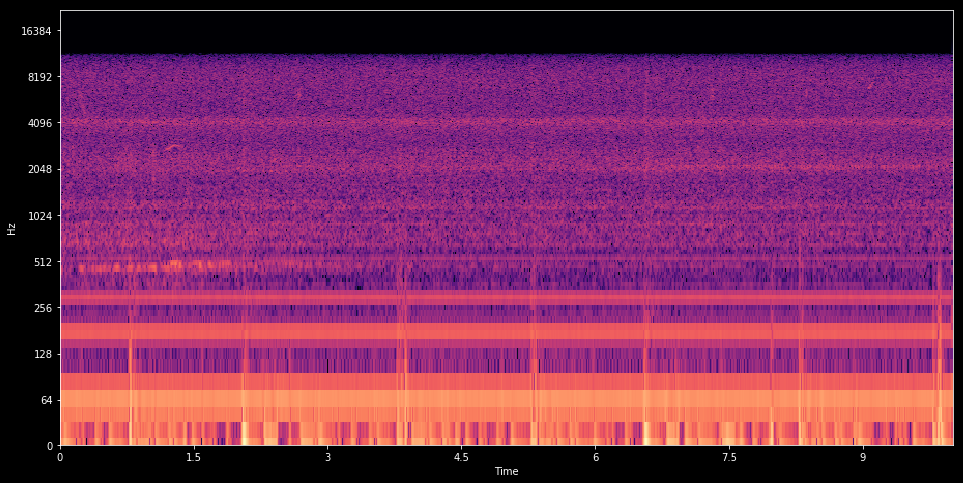

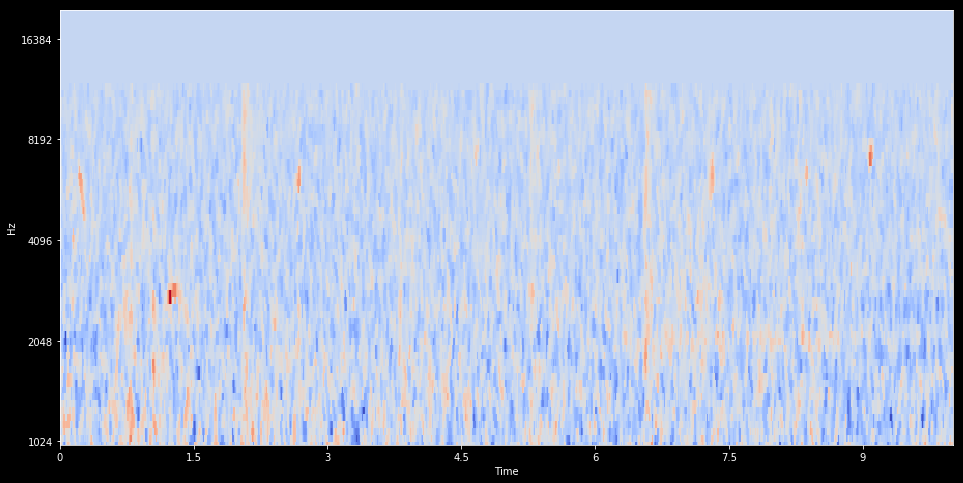

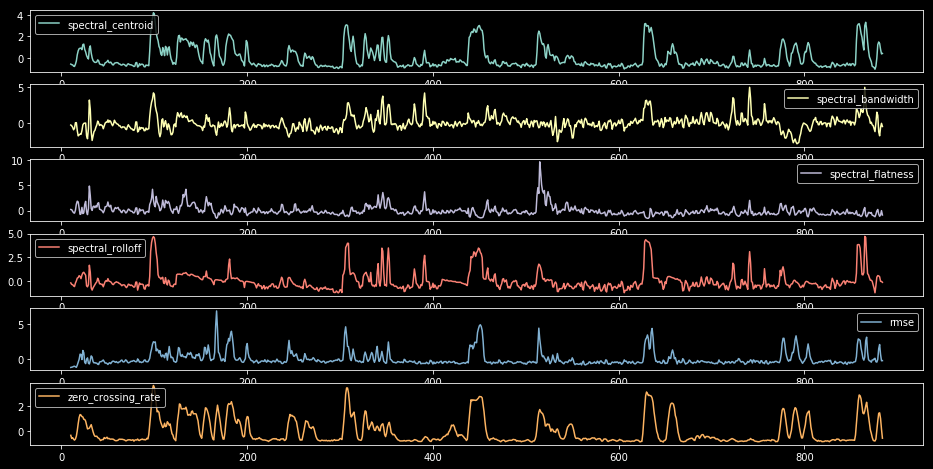

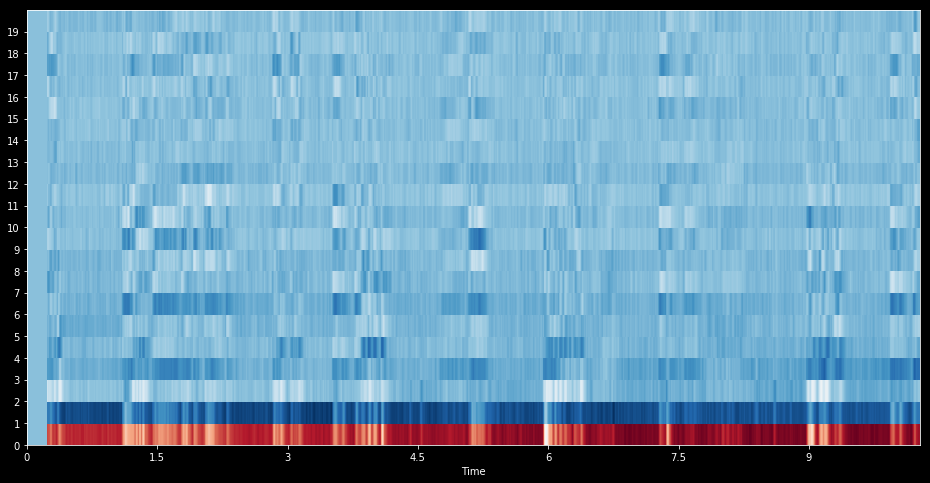

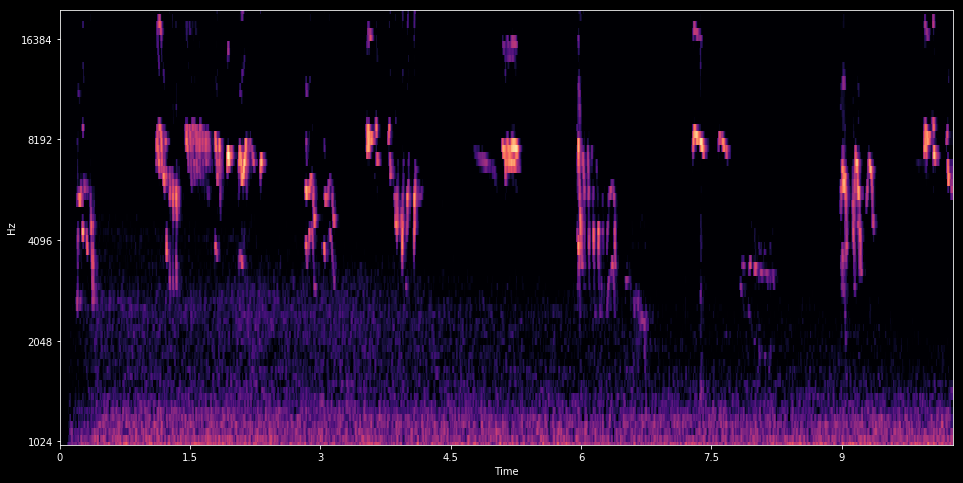

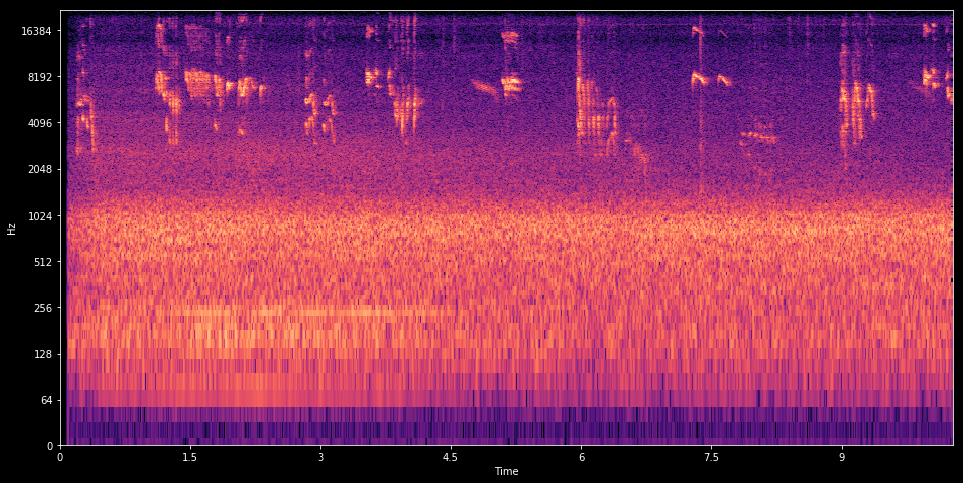

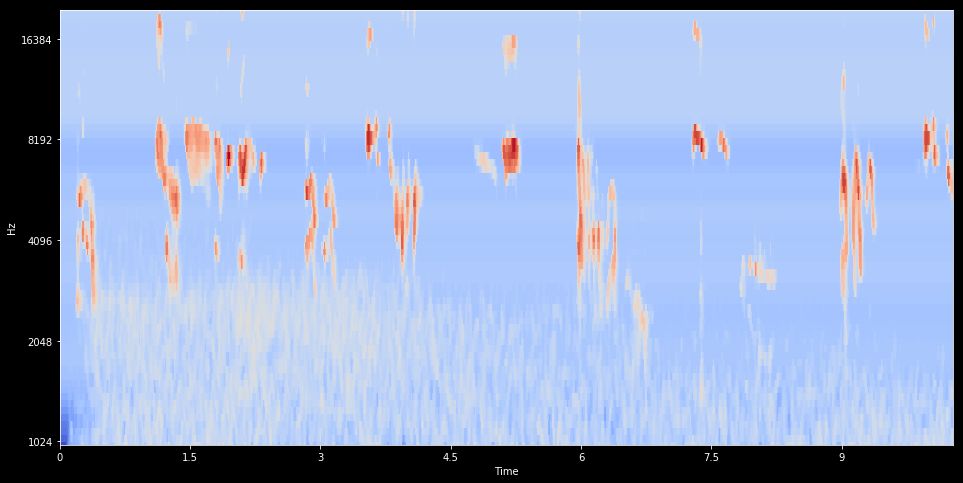

In [59]:
def make_plots():
    files = {
        'bird_noisy': 'sounds/00adbc49-77ef-4b7e-a453-cbb4ee011e11.wav',
        'bird_clear': 'sounds/4dd5046d-c962-4f02-a820.wav',
    }
    plots = {
        'lowlevel': lambda i, o: plot_lowlevel(i, out=o),
        'mfcc': lambda i, o: plot_mfcc(i, out=o),
        'melspec': lambda i, o: plot_melspectrogram(i, out=o),
        'spectrogram': lambda i, o: plot_spectrogram(i, out=o),
        #'waveform': lambda i, o: plot_waveform(i, out=o),
        'melspec_filtered': lambda i, o: plot_melspectrogram(i, out=o, meansubtract=True, medianfilter=(3, 3)),
    }
    for filename, filepath in files.items():
        for plotname, plotfunc in plots.items():
            outname = "images/{}_{}.png".format(filename, plotname)
            plotfunc(filepath, outname)
            print('plotted', outname)
            
make_plots()
        
        